### Critical windows with the causal RF: Analysis Phase 1 ("simple, somewhat realistic")
- The objective of this analysis phase it to perform tests with increasing complexity, from **single exposures** to **multiple exposures**. Multiple exposures may have equal effects (naive), time-varying effects, or concentrated effects over the critical period.  
- All models use random normal distributions for the exposure (based on actual O3 mean and sd) and the outcome (based on actual birth weight mean, sd). One exposure is confounding the critical exposure(s). Of note, O3 exposure and birth weight are approximately normally distributed in the actual data.  
- **Note:** in this analysis phase, exposures are not correlated

**Model 1.A:** a critical exposure  
- 3 exposures: 1 critical, 1 not critical, 1 confounder on critical exposure  

**Model 1.B:** a naive critical window  
- 6 exposures: 3 critical, 2 not critical, 1 confounder on critical exposures  
- CW is naive, with equal (i.e., constant) effects  

**Model 1.C:** a time-varying critical window  
- 6 exposures: 3 critical, 2 not critical, 1 confounder on critical exposures  
- CW is time-varying, with larger effects around a peak (e.g., high in weeks 2, 4; peak in week 3)  

**Model 1.D:** a concentrated critical exposure  
- 6 exposures: 1 critical, 4 not critical, 1 confounder on critical exposure  
- the exposure effect is concentrated (e.g., in week 3); i.e., the full effect of CW in model 1.C is concentrated in a single exposure  
- **Note:** Because exposures are not correlated in Analysis Phase 1, I don't expect the model to struggle with this any more than it would in Model 1.A. It will be interesting to see how the model performs in Analysis Phases 2 and 3, when exposures are correlated.  


In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from econml.dml import LinearDML
from econml.dml import CausalForestDML

In [5]:
np.random.seed(1004) # use throughout

Cohort information
Get the mean and SD for ozone exposure and birth weight.

In [6]:
births = pd.read_csv("data/birth_clean_long.csv")

o3_mean = births['max_o3'].mean()
o3_sd = births['max_o3'].std()

births = births.drop_duplicates(subset = ["momid", "birthweightgrams"])
# ^need to get only unique births, or it'll underweight shorter pregnancies

bw_mean = births["birthweightgrams"].mean()
bw_sd = births["birthweightgrams"].std()


#### Model 1.A
3 exposures: 1 critical, 1 not critical, 1 confounder on critical exposure  

##### "Data"
A few conventions: `T` is treatments, `W` is confounders (aka controls), and `X` is features (includes confounders and covariates, but not treatment). For all models in this project, `X = W`, as there are no covariates, only confounders.

In [7]:
np.random.seed(1004)

n_samples = 5000

n_X = 1
n_T = 2 # one critical, one not, one confounder
n_W = 1

# features (in this case, confounders); z-scaled
X = np.random.normal(size = n_samples, loc = o3_mean, scale = o3_sd) / o3_sd
# treatments / exposures; z-scaled
T_1 = np.random.normal(size = n_samples, loc = o3_mean, scale = o3_sd) / o3_sd
T_2 = np.random.normal(size = n_samples, loc = o3_mean, scale = o3_sd) / o3_sd

Adjust the confounder so it is related to one treatment.

In [8]:
np.random.seed(1004)

## Confounder coefficient
b_W0T1 = 2.5
X = b_W0T1 * T_1 + np.random.normal(size=n_samples)
# a 2.5-unit increase in the confounder increases the exposure by 1 unit
# this is done backwards (tx causes confounder) because later on, we'll use a real tx and synthetic confounder

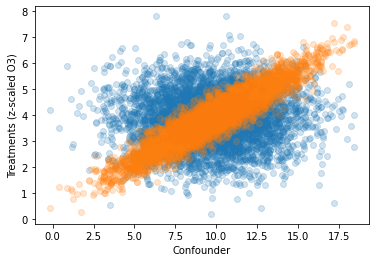

In [84]:
plt.plot(X, T_2, 'o', alpha = 0.2) # unconfounded tx in blue
plt.plot(X, T_1, 'o', alpha = 0.2) # confoundered tx in orange
plt.xlabel("Confounder")
plt.ylabel("Treatments (z-scaled O3)")
plt.show()

Create the outcome

In [10]:
## Coefficients
b_int = bw_mean + 600 # bw_mean for baseline, plus enough to make the predicted mean = bw_mean
b_T1y = -70 # a one-sd increase in o3 decreases bw by 70 g
b_T2y = 0 # the second tx should have no effect
b_W0y = -35 # the confounder also decreases bw by 35 g per one-sd increase

y = b_int + b_T1y * T_1 + b_T2y * T_2 + b_W0y * X

# bw_mean = births["birthweightgrams"].mean()
# bw_sd = births["birthweightgrams"].std()


3259.849548230223
538.4154397780417


161.57245737123975

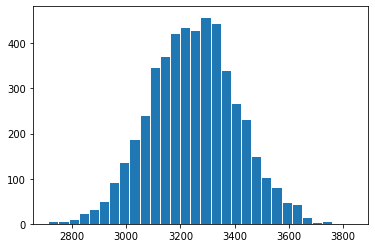

In [11]:
plt.hist(y, bins = 30, edgecolor = "white")
print(bw_mean)
y.mean() # this is about right
print(bw_sd)
y.std() # this is much too small ### will need to rectify this

Correlation between exposures, outcome

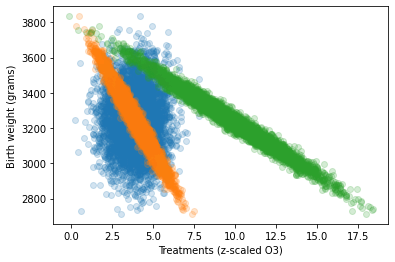

In [89]:
plt.plot(T_2, y, 'o', alpha = 0.2) # unconfounded tx in blue
plt.plot(T_1, y, 'o', alpha = 0.2) # confounded tx in orange
plt.plot(X, y, 'o', alpha = 0.2) # confounder in green
plt.xlabel("Treatments (z-scaled O3)")
plt.ylabel("Birth weight (grams)")
plt.show()

Matrices for treatments, confounders

In [12]:
T = pd.DataFrame({'critical_tx': T_1, 'noncritical_tx': T_2})
X = pd.DataFrame(X, columns=['confounder'])

##### Double ML
Before we go RF, just use `LinearDML`.

In [13]:
model_y = 'linear'
model_t = 'linear'

est = LinearDML(model_y=model_y, model_t=model_t,
                discrete_treatment=False) 

est.fit(y, T=T, W=X, X=X)

In [14]:
est.marginal_ate_inference(T, X)
# note: if we drop the confounder from the model and this code here, the effect of T is inflated

Extract the marginal effects
- `marginal_ate` contains the mean point estimate for treatment effect  
- `marginal_ate_interval` contains the confidence intervals for the mean point estimate  
(This will be important as we scale up the number of treatments)  

In [90]:
res_list = []

for i in range(len(
    est.marginal_ate_interval(T, X)
)):
    current_result = {
        'treatment': est.cate_treatment_names()[i],
        'mean': est.marginal_ate(T, X)[i],
        'ci_lower': est.marginal_ate_interval(T, X)[1][i],
        'ci_upper': est.marginal_ate_interval(T, X)[0][i]
    }

    # append to list
    res_list.append(current_result)

res_df = pd.DataFrame(res_list)
res_df


,treatment,mean,ci_lower,ci_upper
0,critical_tx,-69.587660,-67.876633,-71.298688
1,noncritical_tx,-0.050448,0.557055,-0.657952


Plot the marginal effects

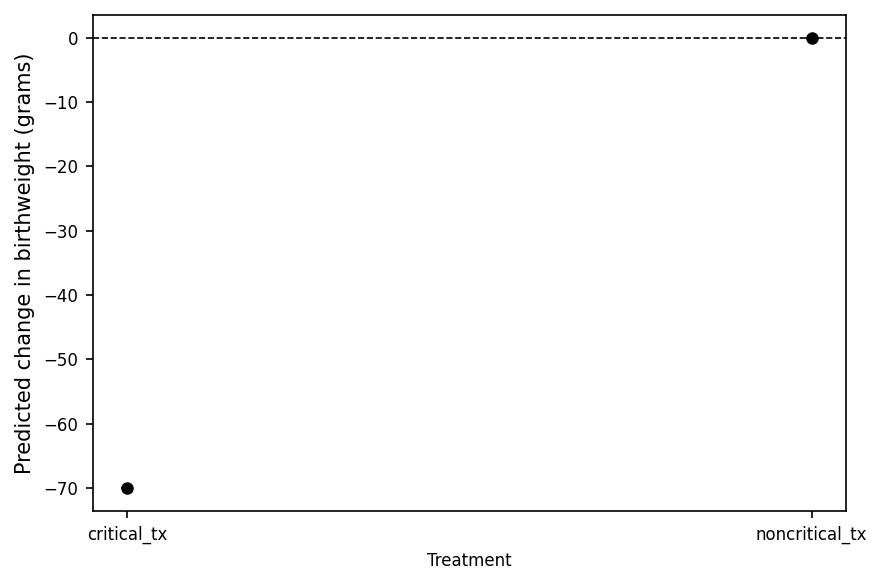

In [71]:
plt.figure(figsize=(6, 4), dpi=150)
ci = np.array([res_df['ci_lower'] - res_df['mean'], res_df['mean'] - res_df['ci_upper'] ])
plt.errorbar(y = res_df['mean'], 
             x = res_df['treatment'], 
            yerr = ci,
            color='black',  capsize=3, linestyle='None', linewidth=1,
            marker="o", markersize=5, mfc="black", mec="black")
plt.axhline(y=0, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Treatment', fontsize=8)
plt.ylabel('Predicted change in birthweight (grams)')
plt.tight_layout()
# plt.labels(res_df['treatment'])
# plt.savefig('raw_forest_plot.png')
plt.show()

##### Causal RF  
Now use the causal RF, same procedures as above.

In [93]:
est = CausalForestDML(model_t='forest',
                      model_y='forest',
                      discrete_treatment=False,
                      n_estimators=500)
est.fit(y, T=T, X=X, W=X)
# note: it takes >100 times longer to run the causal RF over the linear model

Extract the marginal effects

In [75]:
est.marginal_ate_inference(T, X)

In [91]:
res_list = []

for i in range(len(
    est.marginal_ate_interval(T, X)
)):
    current_result = {
        'treatment': est.cate_treatment_names()[i],
        'mean': est.marginal_ate(T, X)[i],
        'ci_lower': est.marginal_ate_interval(T, X)[1][i],
        'ci_upper': est.marginal_ate_interval(T, X)[0][i]
    }

    # append to list
    res_list.append(current_result)

res_df = pd.DataFrame(res_list)
res_df


,treatment,mean,ci_lower,ci_upper
0,critical_tx,-69.587660,-67.876633,-71.298688
1,noncritical_tx,-0.050448,0.557055,-0.657952


Plot the marginal effects

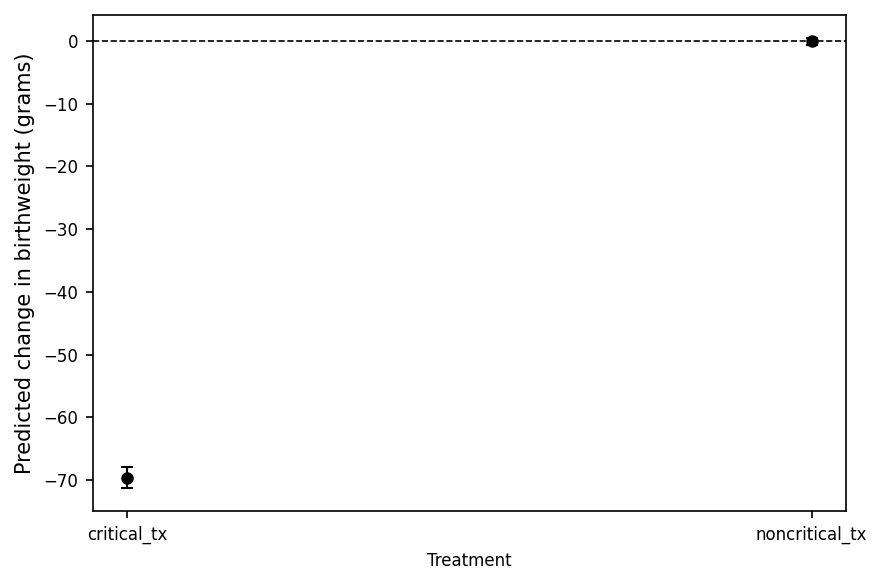

In [77]:
plt.figure(figsize=(6, 4), dpi=150)
ci = np.array([res_df['ci_lower'] - res_df['mean'], res_df['mean'] - res_df['ci_upper'] ])
plt.errorbar(y = res_df['mean'], 
             x = res_df['treatment'], 
            yerr = ci,
            color='black',  capsize=3, linestyle='None', linewidth=1,
            marker="o", markersize=5, mfc="black", mec="black")
plt.axhline(y=0, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Treatment', fontsize=8)
plt.ylabel('Predicted change in birthweight (grams)')
plt.tight_layout()
# plt.savefig('raw_forest_plot.png')
plt.show()

#### Model 1.B
- 6 exposures: 3 critical, 2 not critical, 1 confounder on critical exposures  
- CW is naive, with equal (i.e., constant) effects  

##### "Data"

In [94]:
np.random.seed(1004)

n_samples = 5000

n_X = 1
n_T = 5 # three critical, two not, one confounder
n_W = 1

# features (in this case, confounders); z-scaled
X = np.random.normal(size = n_samples, loc = o3_mean, scale = o3_sd) / o3_sd
# treatments / exposures; z-scaled
T_1 = np.random.normal(size = n_samples, loc = o3_mean, scale = o3_sd) / o3_sd # not critical
T_2 = np.random.normal(size = n_samples, loc = o3_mean, scale = o3_sd) / o3_sd
T_3 = np.random.normal(size = n_samples, loc = o3_mean, scale = o3_sd) / o3_sd
T_4 = np.random.normal(size = n_samples, loc = o3_mean, scale = o3_sd) / o3_sd
T_5 = np.random.normal(size = n_samples, loc = o3_mean, scale = o3_sd) / o3_sd # not critical

Adjust the confounder so it is related to one treatment.

In [165]:
np.random.seed(1004)

## Confounder coefficient
# b_W0T1 = 2.5 # not critical
b_W0T2 = 2.5
b_W0T3 = 2.5
b_W0T4 = 2.5
# b_W0T5 = 2.5 # not critical
X = b_W0T1 * T_2 + b_W0T3 * T_3 + b_W0T4 * T_4 + np.random.normal(size=n_samples) - 40
# a 0.5-unit increase in the confounder increases the exposure by 1 unit
# this is done backwards (tx causes confounder) because later on, we'll use a real tx and synthetic confounder

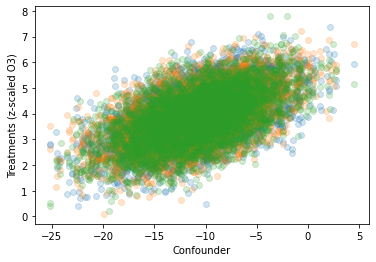

In [166]:
# plt.plot(X, T_5, 'o', alpha = 0.2) # not critical, unconfounded
plt.plot(X, T_4, 'o', alpha = 0.2)
plt.plot(X, T_3, 'o', alpha = 0.2)
plt.plot(X, T_2, 'o', alpha = 0.2) 
# plt.plot(X, T_1, 'o', alpha = 0.2) # not critical, unconfounded
plt.xlabel("Confounder")
plt.ylabel("Treatments (z-scaled O3)")
plt.show()

Create the outcome

In [171]:
## Coefficients
b_int = bw_mean + 400 # bw_mean for baseline, plus enough to make the predicted mean = bw_mean
b_T2y = 0 # not critical, no effect
b_T2y = -70 # a one-sd increase in o3 decreases bw by 70 g
b_T3y = -70 # a one-sd increase in o3 decreases bw by 70 g
b_T4y = -70 # a one-sd increase in o3 decreases bw by 70 g
b_T5y = 0 # not critical, no effect
b_W0y = -35 # the confounder also decreases bw by 75 g per one-sd increase

y = b_int + b_T1y * T_1 + b_T2y * T_2 + b_T3y * T_3 + b_T4y * T_4 + b_T5y * T_5 + b_W0y * X

# bw_mean = births["birthweightgrams"].mean()
# bw_sd = births["birthweightgrams"].std()


3259.849548230223
3226.8093868000105
538.4154397780417


269.7587938675763

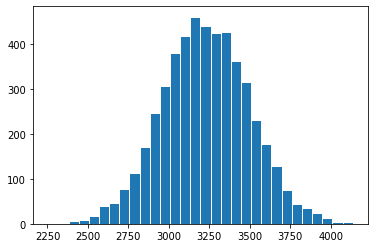

In [172]:
plt.hist(y, bins = 30, edgecolor = "white")
print(bw_mean)
print(y.mean()) # this is about right
print(bw_sd)
y.std() # this is too small ### will need to rectify this

Correlation between exposures, confounder, outcome

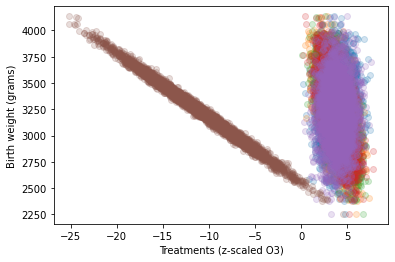

In [175]:
plt.plot(T_5, y, 'o', alpha = 0.2) # unconfounded tx in blue
plt.plot(T_4, y, 'o', alpha = 0.2) # unconfounded tx in blue
plt.plot(T_3, y, 'o', alpha = 0.2) # unconfounded tx in blue
plt.plot(T_2, y, 'o', alpha = 0.2) # unconfounded tx in blue
plt.plot(T_1, y, 'o', alpha = 0.2) # confounded tx in orange
plt.plot(X, y, 'o', alpha = 0.2) # confounder in green
plt.xlabel("Treatments (z-scaled O3)")
plt.ylabel("Birth weight (grams)")
plt.show()

Matrices for treatments, confounders, outcome

In [189]:
T = pd.DataFrame({'noncritical_tx_1': T_1, 'critical_tx_2': T_2,
                  'critical_tx_3': T_3, 'critical_tx_4': T_4,
                  'noncritical_tx_5': T_5})
X = pd.DataFrame(X, columns=['confounder'])

##### Causal RF

In [190]:
est = CausalForestDML(model_t='forest',
                      model_y='forest',
                      discrete_treatment=False,
                      n_estimators=500)
est.fit(y, T=T, X=X, W=X)
# note: it takes >100 times longer to run the causal RF over the linear model

Extract the marginal effects

In [191]:
est.marginal_ate_inference(T, X)

In [193]:
res_list = []

for i in range(n_T):
    current_result = {
        'treatment': est.cate_treatment_names()[i],
        'mean': est.marginal_ate(T, X)[i],
        'ci_lower': est.marginal_ate_interval(T, X)[1][i],
        'ci_upper': est.marginal_ate_interval(T, X)[0][i]
    }

    # append to list
    res_list.append(current_result)

res_df = pd.DataFrame(res_list)
res_df


,treatment,mean,ci_lower,ci_upper
0,noncritical_tx_1,0.056568,0.682411,-0.569276
1,critical_tx_2,-70.017879,-67.892288,-72.143469
2,critical_tx_3,-69.981281,-67.632200,-72.330362
3,critical_tx_4,-69.944011,-67.717115,-72.170907
4,noncritical_tx_5,0.047615,0.694750,-0.599519


Plot the marginal effects

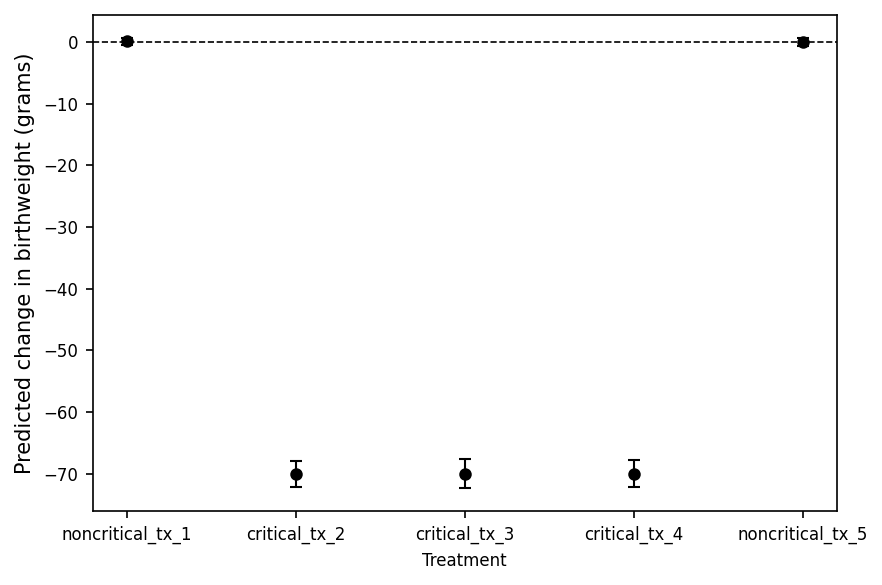

In [194]:
plt.figure(figsize=(6, 4), dpi=150)
ci = np.array([res_df['ci_lower'] - res_df['mean'], res_df['mean'] - res_df['ci_upper'] ])
plt.errorbar(y = res_df['mean'], 
             x = res_df['treatment'], 
            yerr = ci,
            color='black',  capsize=3, linestyle='None', linewidth=1,
            marker="o", markersize=5, mfc="black", mec="black")
plt.axhline(y=0, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Treatment', fontsize=8)
plt.ylabel('Predicted change in birthweight (grams)')
plt.tight_layout()
# plt.savefig('raw_forest_plot.png')
plt.show()

#### Model 1.C
- 6 exposures: 3 critical, 2 not critical, 1 confounder on critical exposures  
- CW is time-varying, with larger effects around a peak (e.g., high in weeks 2, 4; peak in week 3)  

##### "Data"

In [195]:
np.random.seed(1004)

n_samples = 5000

n_X = 1
n_T = 5 # three critical, two not, one confounder
n_W = 1

# features (in this case, confounders); z-scaled
X = np.random.normal(size = n_samples, loc = o3_mean, scale = o3_sd) / o3_sd
# treatments / exposures; z-scaled
T_1 = np.random.normal(size = n_samples, loc = o3_mean, scale = o3_sd) / o3_sd # not critical
T_2 = np.random.normal(size = n_samples, loc = o3_mean, scale = o3_sd) / o3_sd
T_3 = np.random.normal(size = n_samples, loc = o3_mean, scale = o3_sd) / o3_sd
T_4 = np.random.normal(size = n_samples, loc = o3_mean, scale = o3_sd) / o3_sd
T_5 = np.random.normal(size = n_samples, loc = o3_mean, scale = o3_sd) / o3_sd # not critical

Adjust the confounder so it is related to one treatment.

In [197]:
np.random.seed(1004)

## Confounder coefficient
# b_W0T1 = 2.5 # not critical
b_W0T2 = 2.5
b_W0T3 = 2.5
b_W0T4 = 2.5
# b_W0T5 = 2.5 # not critical
X = b_W0T1 * T_2 + b_W0T3 * T_3 + b_W0T4 * T_4 + np.random.normal(size=n_samples) - 40
# a 0.5-unit increase in the confounder increases the exposure by 1 unit
# this is done backwards (tx causes confounder) because later on, we'll use a real tx and synthetic confounder

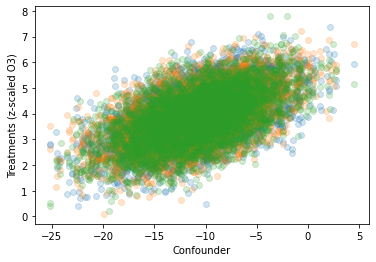

In [198]:
# plt.plot(X, T_5, 'o', alpha = 0.2) # not critical, unconfounded
plt.plot(X, T_4, 'o', alpha = 0.2)
plt.plot(X, T_3, 'o', alpha = 0.2)
plt.plot(X, T_2, 'o', alpha = 0.2) 
# plt.plot(X, T_1, 'o', alpha = 0.2) # not critical, unconfounded
plt.xlabel("Confounder")
plt.ylabel("Treatments (z-scaled O3)")
plt.show()

Create the outcome

In [199]:
## Coefficients
b_int = bw_mean + 400 # bw_mean for baseline, plus enough to make the predicted mean = bw_mean
b_T2y = 0 # not critical, no effect
b_T2y = -60 # a one-sd increase in o3 decreases bw by 70 g
b_T3y = -90 # a one-sd increase in o3 decreases bw by 70 g
b_T4y = -60 # a one-sd increase in o3 decreases bw by 70 g
b_T5y = 0 # not critical, no effect
b_W0y = -35 # the confounder also decreases bw by 75 g per one-sd increase

y = b_int + b_T1y * T_1 + b_T2y * T_2 + b_T3y * T_3 + b_T4y * T_4 + b_T5y * T_5 + b_W0y * X

# bw_mean = births["birthweightgrams"].mean()
# bw_sd = births["birthweightgrams"].std()


3259.849548230223
3226.51781566956
538.4154397780417


270.95978007644067

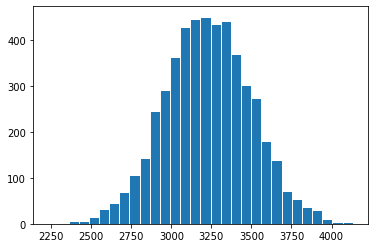

In [200]:
plt.hist(y, bins = 30, edgecolor = "white")
print(bw_mean)
print(y.mean()) # this is about right
print(bw_sd)
y.std() # this is too small ### will need to rectify this

Correlation between exposures, outcome, confounder

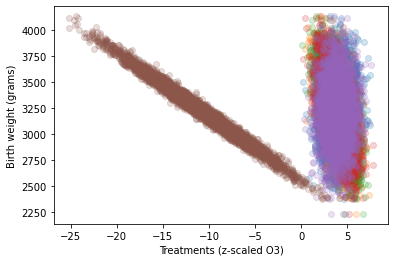

In [201]:
plt.plot(T_5, y, 'o', alpha = 0.2) # unconfounded tx in blue
plt.plot(T_4, y, 'o', alpha = 0.2) # unconfounded tx in blue
plt.plot(T_3, y, 'o', alpha = 0.2) # unconfounded tx in blue
plt.plot(T_2, y, 'o', alpha = 0.2) # unconfounded tx in blue
plt.plot(T_1, y, 'o', alpha = 0.2) # confounded tx in orange
plt.plot(X, y, 'o', alpha = 0.2) # confounder in green
plt.xlabel("Treatments (z-scaled O3)")
plt.ylabel("Birth weight (grams)")
plt.show()

Matrices for treatments, confounder, outcome

In [202]:
T = pd.DataFrame({'noncritical_tx_1': T_1, 'critical_tx_2': T_2,
                  'critical_tx_3': T_3, 'critical_tx_4': T_4,
                  'noncritical_tx_5': T_5})
X = pd.DataFrame(X, columns=['confounder'])

##### Causal RF

In [203]:
est = CausalForestDML(model_t='forest',
                      model_y='forest',
                      discrete_treatment=False,
                      n_estimators=500)
est.fit(y, T=T, X=X, W=X)

Extract marginal effects

In [204]:
est.marginal_ate_inference(T, X)

In [207]:
est.marginal_ate_interval(T, X)[1]

array([  0.95986374, -57.60171883, -87.310824  , -57.51697209,
         0.93563326])

In [205]:
res_list = []

for i in range(n_T):
    current_result = {
        'treatment': est.cate_treatment_names()[i],
        'mean': est.marginal_ate(T, X)[i],
        'ci_lower': est.marginal_ate_interval(T, X)[1][i],
        'ci_upper': est.marginal_ate_interval(T, X)[0][i]
    }

    # append to list
    res_list.append(current_result)

res_df = pd.DataFrame(res_list)
res_df


,treatment,mean,ci_lower,ci_upper
0,noncritical_tx_1,0.104862,0.959864,-0.750139
1,critical_tx_2,-59.859154,-57.601719,-62.116590
2,critical_tx_3,-89.850910,-87.310824,-92.390996
3,critical_tx_4,-59.949751,-57.516972,-62.382531
4,noncritical_tx_5,0.042946,0.935633,-0.849741


Plot the marginal effects

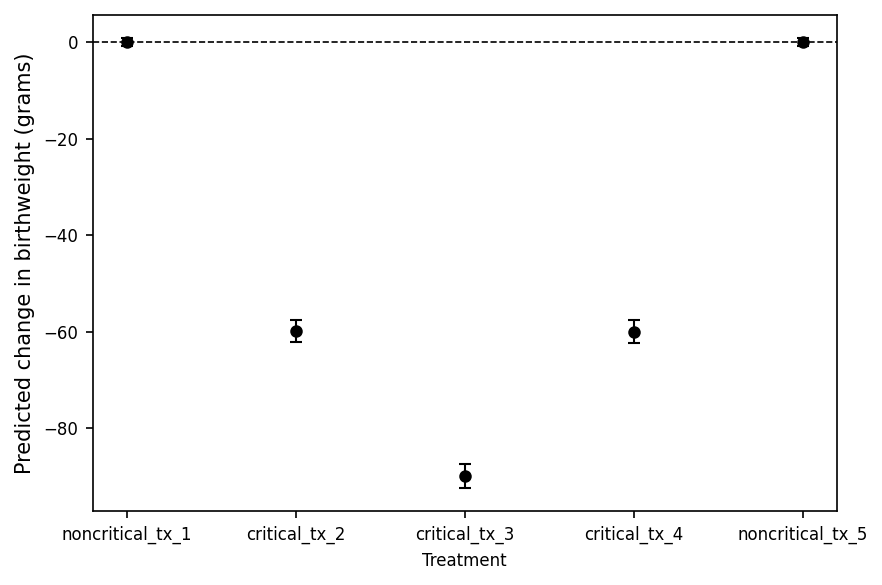

In [206]:
plt.figure(figsize=(6, 4), dpi=150)
ci = np.array([res_df['ci_lower'] - res_df['mean'], res_df['mean'] - res_df['ci_upper'] ])
plt.errorbar(y = res_df['mean'], 
             x = res_df['treatment'], 
            yerr = ci,
            color='black',  capsize=3, linestyle='None', linewidth=1,
            marker="o", markersize=5, mfc="black", mec="black")
plt.axhline(y=0, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Treatment', fontsize=8)
plt.ylabel('Predicted change in birthweight (grams)')
plt.tight_layout()
# plt.savefig('raw_forest_plot.png')
plt.show()